# Kaggle Challenge: Predict Survival on the Titanic

## Libraries and Data Load in

In [36]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [87]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import plotly.express as px
import seaborn as sns

from xgboost import XGBClassifier

In [103]:
train_data=pd.read_csv("./data/train.csv")
train_data.head()
train_data.shape
test_data=pd.read_csv("./data/test.csv")
test_data.head()
test_data.shape

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


(891, 12)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


(418, 11)

## Data Preprocessing

In [67]:
#check for missing data
np.sum(pd.isna(train_data))
np.sum(pd.isna(test_data))

/home/fbazzi19/anaconda3/envs/kaggle_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Age and Cabin features are missing for many passengers, so they will be removed as features. Fare and embarked are missing for very few passengers and show a correlation with survival, so the passengers missing that data will be removed.

In [104]:
#removing columns
train_data = train_data.drop(columns=['Age', 'Cabin', 'Name', 'Ticket'])
test_data = test_data.drop(columns=['Age', 'Cabin', 'Name', 'Ticket'])

In [105]:
#removing rows
train_data = train_data.drop(train_data[pd.isna(train_data['Embarked'])].index)
#test_data = test_data.drop(test_data[pd.isna(test_data['Fare'])].index)

In [45]:
#check for missing data
np.sum(pd.isna(train_data))
np.sum(pd.isna(test_data))

/home/fbazzi19/anaconda3/envs/kaggle_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PassengerId    0
Survived       0
Pclass         0
Sex            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

PassengerId    0
Pclass         0
Sex            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [106]:
#one-hot encoding of Pclass and Embarked
#train data
train_data = pd.get_dummies(train_data, columns=['Pclass', 'Sex', 'Embarked'], drop_first=True)
train_data.head()
#test data
test_data = pd.get_dummies(test_data, columns=['Pclass', 'Sex', 'Embarked'], drop_first=True)
test_data.head()

,PassengerId,Survived,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,1,0,1,0,7.2500,False,True,True,False,True
1,2,1,1,0,71.2833,False,False,False,False,False
2,3,1,0,0,7.9250,False,True,False,False,True
3,4,1,1,0,53.1000,False,False,False,False,True
4,5,0,0,0,8.0500,False,True,True,False,True


,PassengerId,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,892,0,0,7.8292,False,True,True,True,False
1,893,1,0,7.0000,False,True,False,False,True
2,894,0,0,9.6875,True,False,True,True,False
3,895,0,0,8.6625,False,True,True,False,True
4,896,1,1,12.2875,False,True,False,False,True


<Figure size 1500x1500 with 0 Axes>

<Axes: >

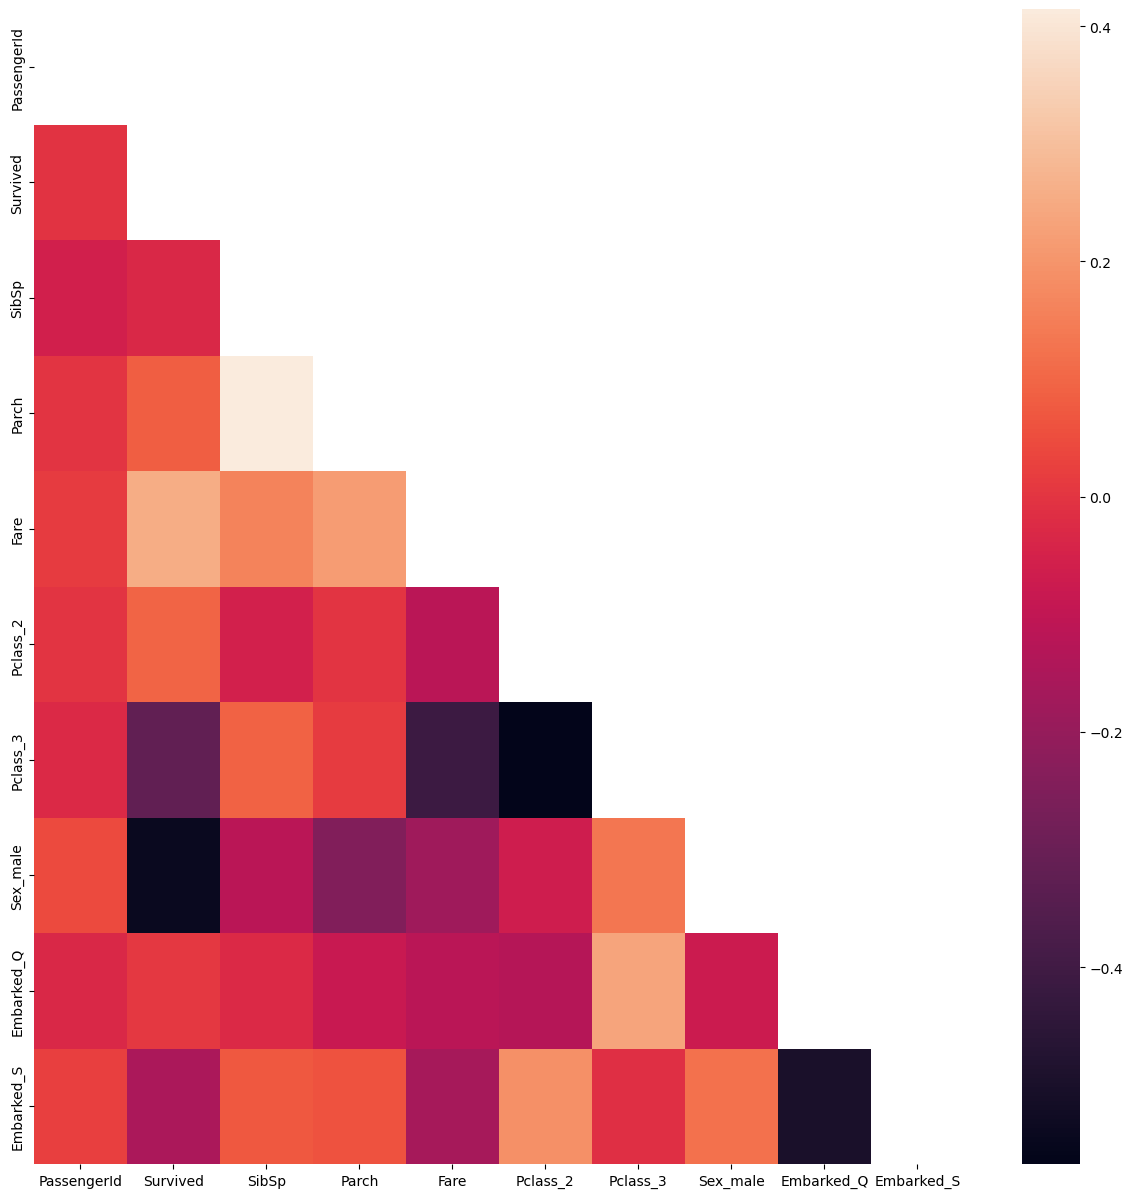

<Figure size 1500x1500 with 0 Axes>

<Axes: >

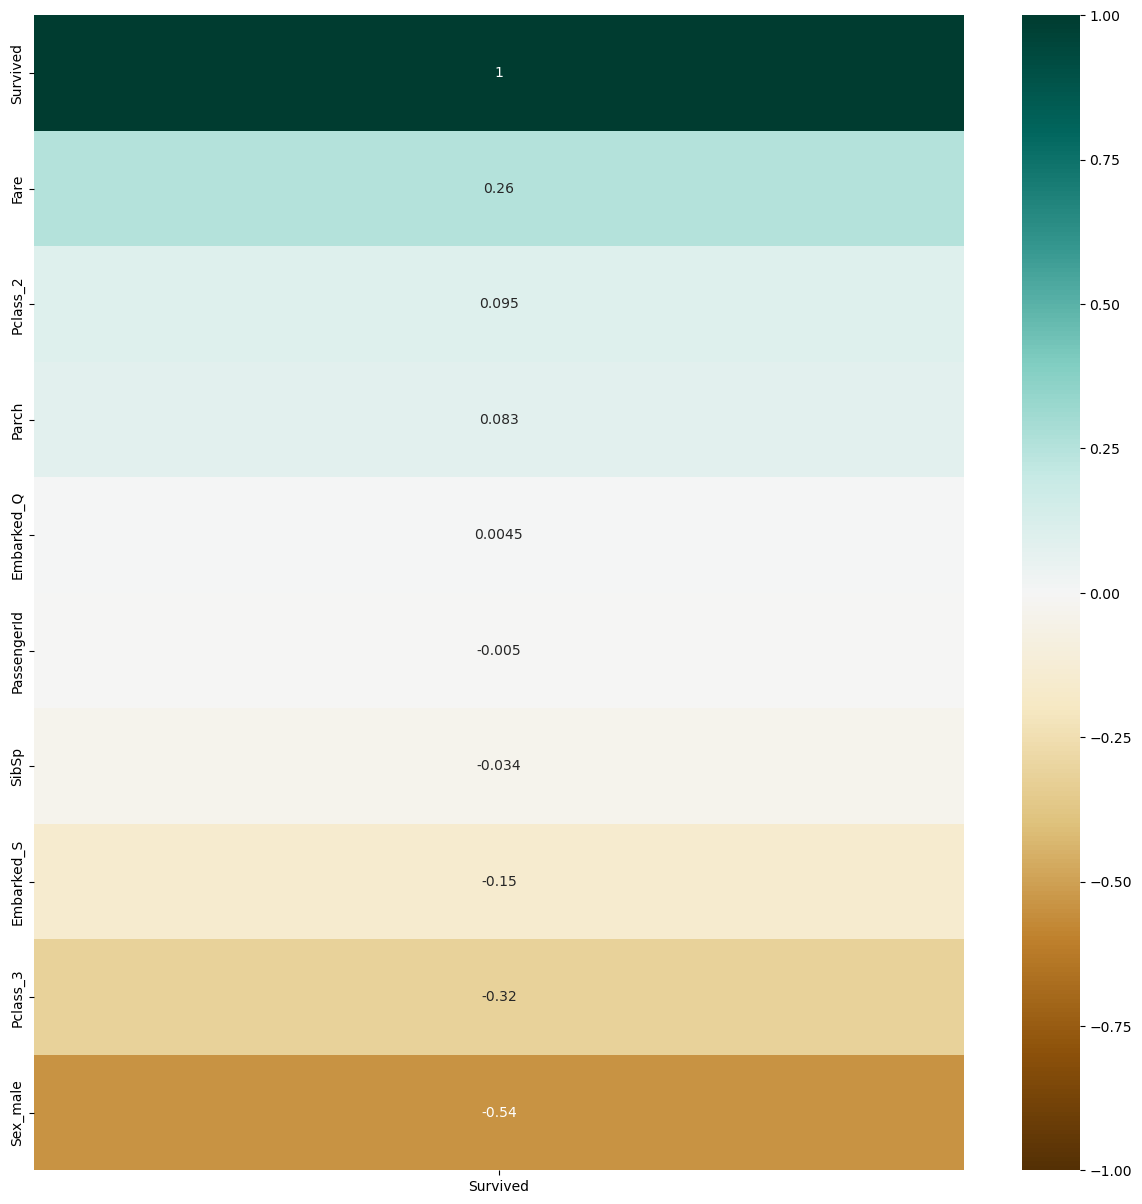

In [107]:
#check correlation of different features to survived
corr = train_data.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
#display the heatmap
plt.figure(figsize=(15,15))
sns.heatmap(corr, mask=mask)
plt.show()
#display the correlation specifically for survival
plt.figure(figsize=(15,15))
sns.heatmap(train_data.corr(numeric_only=True)[['Survived']].sort_values(by='Survived', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.show()

Split into X and y

In [108]:
train_data = train_data.set_index('PassengerId')
pid=test_data['PassengerId']
test_data = test_data.set_index('PassengerId')
X_train = train_data.drop(columns=['Survived'])
y_train = train_data['Survived']
X_train.head()
y_train.head()

,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,
1,1,0,7.2500,False,True,True,False,True
2,1,0,71.2833,False,False,False,False,False
3,0,0,7.9250,False,True,False,False,True
4,1,0,53.1000,False,False,False,False,True
5,0,0,8.0500,False,True,True,False,True


PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Survived, dtype: int64

array([[  0,   1],
       [549, 340]])

(array([549.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 340.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

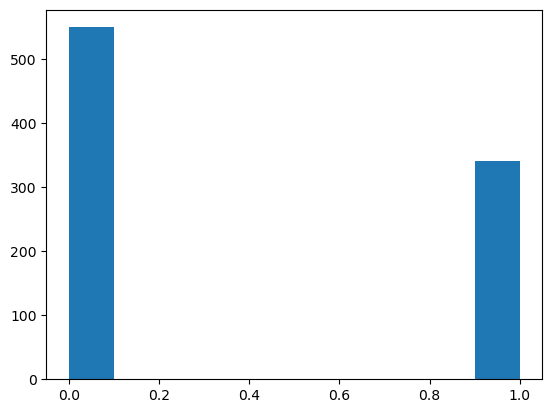

In [34]:
np.asarray(np.unique(train_data['Survived'], return_counts=True))
plt.hist(train_data['Survived'], label="Train")

## XGBoost Model

In [109]:
# create model instance
bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
# fit model
bst.fit(X_train, y_train)
# make predictions
preds = bst.predict(test_data)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=2,
              n_jobs=None, num_parallel_tree=None, ...)

In [110]:
pid

0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

In [111]:
results = pd.DataFrame(np.transpose([pid, pd.Series(preds)]), columns=['PassengerId', 'Survived'])

In [112]:
results.to_csv('xgboost_predictions.csv', index=False)